In [1]:
import h5py
from tqdm import tqdm
import librosa
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import cv2
import sys
import matplotlib.pyplot as plt

In [2]:
classes13 = {
  "Pipistrellus pipistrellus": 0,
  "Pipistrellus nathusii": 1,
  "Pipistrellus kuhlii": 2,
  "Myotis daubentonii": 3,
  "Nyctalus noctula": 4,
  "Nyctalus leisleri": 5,
  "Eptesicus serotinus": 6,
  "Myotis dasycneme": 7,
  "Miniopterus schreibersii": 8,
  "Vespertilio murinus": 9,
  "Rhinolophus ferrumequinum": 10,
  "Myotis emarginatus": 11,
  "Myotis myotis": 12,
}

classes23 = {
  "Pipistrellus pipistrellus": 0,
  "Pipistrellus nathusii": 1,
  "Pipistrellus kuhlii": 2,
  "Myotis daubentonii": 3,
  "Nyctalus noctula": 4,
  "Nyctalus leisleri": 5,
  "Myotis nattereri": 6,
  "Eptesicus serotinus": 7,
  "Myotis dasycneme": 8,
  "Miniopterus schreibersii": 9,
  "Vespertilio murinus": 10,
  "Rhinolophus ferrumequinum": 11,
  "Rhinolophus hipposideros": 12,
  "Myotis brandtii": 13,
  "Myotis mystacinus": 14,
  "Myotis emarginatus": 15,
  "Myotis myotis": 16,
  "Pipistrellus pygmaeus": 17,
  "Hypsugo savii": 18,
  "Eptesicus nilssonii": 19,
  "Tadarida teniotis": 20,
  "Myotis capaccinii": 21,
  "Pipistrellus maderensis": 22,
  "Rhinolophus blasii": 23
}

labels = classes13

In [3]:
prepared_hf = h5py.File('prepared.h5', 'r')

In [4]:
sample_rate = 22050                          # recordings are in 96 kHz, 24 bit depth, 1:10 TE (mic sr 960 kHz), 22050 Hz = 44100 Hz TE
n_fft = 512                                  # 23 ms * 22050 Hz
frame_rate = int(sample_rate / (n_fft // 4)) # 22050 / 128 ~ 172

patch_len = 44                               # = 250ms ~ 25ms
patch_skip = 22                              # = 150ms ~ 15ms
seq_len = 60                                 # = 500ms with ~ 5 calls
seq_skip = 15

In [5]:
def slideWindow(a, size, step):
    b = []
    i = 0
    pos = 0
    while pos + size < len(a):
        pos = int(i * step)
        b.append(a[pos : pos + size])
        i+=1
    return b

def getSequences(spectrogram, patch_len, patch_skip, seq_len, seq_skip):
    tiles = slideWindow(spectrogram, size=patch_len, step=patch_skip)[:-1] # last one is not full
    sequences = slideWindow(tiles, size=seq_len, step=seq_skip)[:-1] # last one is not full
    return sequences

In [6]:
def prepareSet(prepared_set, labels, patch_len, patch_skip, seq_len, seq_skip, scale_factor, one_hot):
    X_seq = []
    Y_seq = []
    
    for species in tqdm(list(labels)):
        S_db = prepared_set.get(species)
        new_size = (int(S_db.shape[1] * scale_factor), int(S_db.shape[0] * scale_factor))
        S_db = cv2.resize(np.float32(S_db), dsize=new_size, interpolation=cv2.INTER_NEAREST)
        label = to_categorical(labels[species], num_classes=len(labels)) if one_hot else labels[species]

        seq = getSequences(S_db, patch_len, patch_skip, seq_len, seq_skip)
        X_seq.extend(seq)
        Y_seq.extend([label] * len(seq))
    
    X_seq, Y_seq = shuffle(X_seq, Y_seq, random_state=42)
    return np.asarray(X_seq), np.asarray(Y_seq)

def prepare(file, labels, patch_len, patch_skip, seq_len, seq_skip, scale_factor = 1.0, one_hot=False):
    prepared_hf = h5py.File(file, 'r')
    X_train, Y_train = prepareSet(prepared_hf.require_group("train"), labels, patch_len, patch_skip, seq_len, seq_skip, scale_factor, one_hot)
    X_test, Y_test = prepareSet(prepared_hf.require_group("test"), labels, patch_len, patch_skip, seq_len, seq_skip, scale_factor, one_hot)
    X_val, Y_val = prepareSet(prepared_hf.require_group("val"), labels, patch_len, patch_skip, seq_len, seq_skip, scale_factor, one_hot)
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

In [7]:
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../datasets/prepared.h5", classes13, patch_len, patch_skip, seq_len, seq_skip)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


In [8]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total sequences: 16813
(9897, 60, 44, 257) (9897,)


In [9]:
def plot_patch(patch, y):
    plt.figure(figsize = (5, 10))
    spec = np.rot90(patch)
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    plt.title(list(labels)[y])

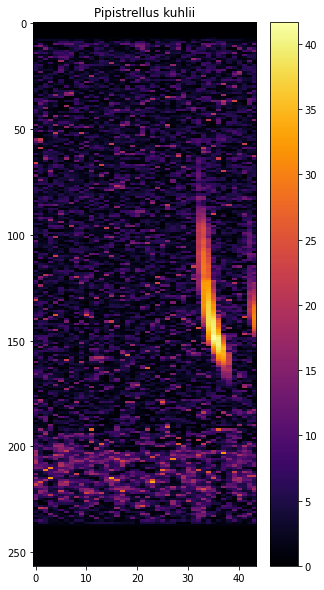

In [10]:
plot_patch(X_train[1][0], Y_train[1])

In [11]:
def stitch(a, r):
    return a[::r]
  
def plot_sequence(seq, y):
    plt.figure(figsize = (20, 2.5))
    stitched = stitch(seq, int(patch_len / patch_skip))
    spec = np.rot90(np.concatenate(stitched))
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    plt.title(list(labels)[y])

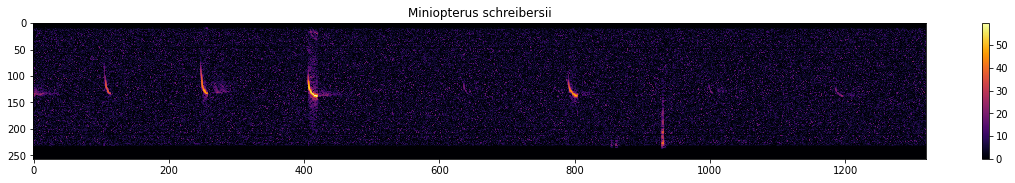

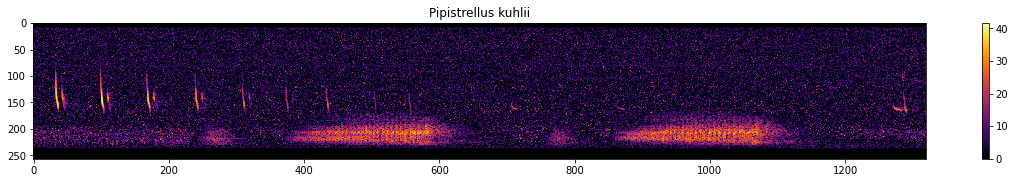

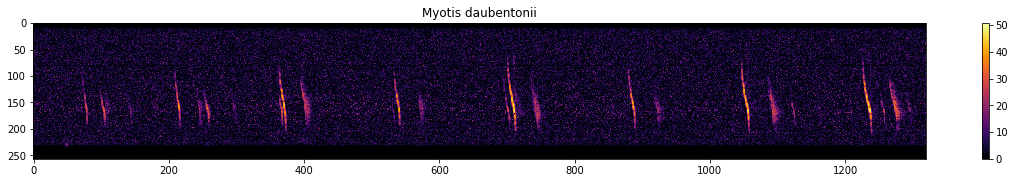

In [12]:
plot_sequence(X_train[0], Y_train[0])
plot_sequence(X_train[1], Y_train[1])
plot_sequence(X_train[3], Y_train[3])